In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import importlib

In [2]:
import sys
sys.path.append('~/Modules/deep-retina/')
sys.path.append('~/Modules/drone/')
import deepretina
#import drone
from deepretina.core import load
from deepretina.experiments import rolling_window
from deepretina.metrics import cc

Using TensorFlow backend.


In [3]:
#from aesthetics.plotting import adjust_spines
from scipy.stats import sem, pearsonr
from sklearn.cluster import KMeans
from tqdm import tqdm
import os
import pickle
import re
import h5py
import collections
import pyret
import pyret.filtertools as ft
from pyret.nonlinearities import Binterp, RBF, Sigmoid
from pyret.visualizations import plot_sta
# ft.linear_response has a different dimension before version '0.6.0'
pyret.__version__

'0.6.0'

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#plt.style.use('deepretina2')
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
%matplotlib inline

In [5]:
# My module
#sys.path.insert(0,'~/Modules/')
sys.path.insert(0,'..') # include parent folder
import my

## Data open

In [6]:
pwd

'/home/juyoung/Modules/1d-whitenoise-models'

In [7]:
# List data files (DL intracellular recording data)
from os import listdir
from os.path import isfile, join
# all npy files:
data_dir = '/home/juyoung/Modules/1d-whitenoise-models/data-DL-npy/'
files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
files = [f for f in files if '.npy' in f]
files = [f for f in files if 'cell' in f]
files

['cell__011__resp_17-10-26-r1-c1-1-line.h5.npy',
 'cell__008__resp_17-10-26-r2-c3-1-line.h5.npy',
 'cell__009__resp_17-11-14-r1-c8-1-line.h5.npy',
 'cell__003__resp_17-11-07-r1-c5-1-line.h5.npy',
 'cell__006__resp_17-07-03-r1-c6-1-line.h5.npy',
 'cell__005__resp_17-11-08-r1-c5-1-line.h5.npy',
 'cell__007__resp_17-11-06-r1-c1-1-line.h5.npy',
 'cell__002__resp_18-03-13-r3-c2-1-line.h5.npy']

In [8]:
# Load stimulus sequence
stim = np.load(data_dir + './stim-whitenoise.npy')
# stim frame parameters
frame_time = 0.01666574578544061 / 8 # upsampling factor = 8. For moving bar, 16.
nbins_time = np.int( 0.5 / frame_time ) # 500 ms
rolling_size = nbins_time

In [9]:
n_cell = len(files)
data = [dict() for c in range(n_cell)] # data as dictionary for flexibility. Data would have varisous kinds of keys for acquired data type. 

# Load data with appropriate key name
for i in range(n_cell):
    data[i]['vol'] = np.load(data_dir+files[i])    

In [10]:
# Convert list to 2d array for 'labels' (CNN model: fitting simultaneously to multiple cell data)
labels = [data[i]['vol'] for i in range(n_cell)] # List
labels = np.array(labels)                       
labels.shape 

(8, 71900)

### Sanity check that this alignment is correct

In [11]:
#pyret.visualizations.__all__

In [ ]:
# rev correlation by pyret
importlib.reload(pyret)
plt.rcParams['figure.figsize'] = [10, 3];

for c in range(n_cell):
        rc, lags = ft.revcorr(stim, labels[c], rolling_size)
        ax1 = plt.subplot(1, 2, 1)
        ax2 = plt.subplot(1, 2, 2)
        pyret.visualizations.spatial(rc, dx=1.0, ax = ax1)
        #pyret.visualizations.temporal(lags, rc, ax = ax2)

['seaborn-dark', 'seaborn-whitegrid', 'seaborn-colorblind', 'classic', 'seaborn-ticks', 'seaborn-white', 'seaborn-bright', 'seaborn-dark-palette', 'seaborn-darkgrid', 'tableau-colorblind10', 'seaborn', 'fast', 'seaborn-deep', 'seaborn-pastel', 'dark_background', 'grayscale', 'ggplot', 'seaborn-talk', '_classic_test', 'seaborn-muted', 'seaborn-paper', 'seaborn-notebook', 'Solarize_Light2', 'fivethirtyeight', 'bmh', 'seaborn-poster']


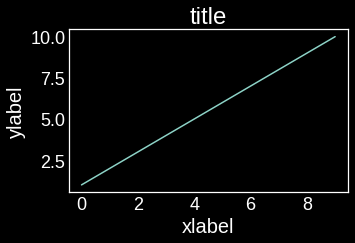

In [12]:
# Figure setting
plt.rcParams['figure.figsize'] = [5, 3]
# plot style test
print(plt.style.available)
#plt.style.use(['classic'])
plt.style.use(['seaborn-white','dark_background'])
plt.style.use(['dark_background'])
# plt.style.use('seaborn-dark') # Working in dark theme jupyter lab. Figures for white presentation
#
plt.rcParams['font.size'] = 20
#plt.rcParams['axes.labelsize'] = 40
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
#
a = np.linspace(1, 10, 10)
plt.plot(a)
plt.xlabel('xlabel')
plt.ylabel('ylabel')
plt.title('title')
plt.axis('on')
# etc
#ax2.xaxis.grid()
#ax2.set_xlim([0,n_data_res])
#ax2.set_yticklabels([])
plt.show()

## LN model

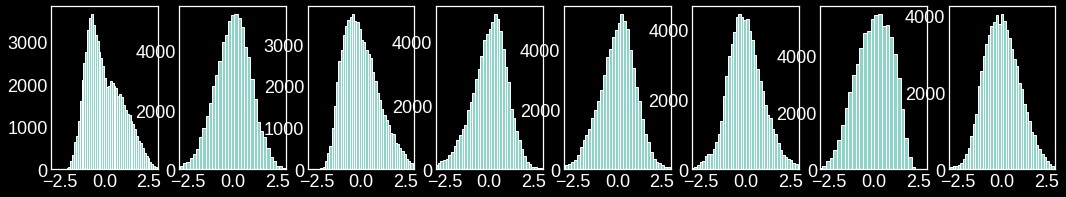

In [13]:
# Centering data?
#labels -= np.mean(labels, axis=1)
#labels /= np.std(labels, axis=1)

# Input range histogram: Is it standardized distribution?
plt.rcParams['figure.figsize'] = [18, 3]
plt.figure()
for c in range(n_cell):
    ax = plt.subplot(1, n_cell, c+1)
    ax.hist(labels[c], bins=50, ec='w');
    ax.set_xlim([-3,3])

In [45]:
rr = {key:2 for key in dataset}
print(rr)
type(rr)

{'training': 2, 'test': 2, 'test2': 2}


dict

In [59]:
# Correlation result data structure (dictionary) 
# model_r[cell id] [data set][model_name]
models = ["L","LN","2L-CNN"]
dataset = ["training", "test", "test2"]
values = np.zeros(len(models))

model_r = [dict() for i in range(n_cell)]

for i in range(n_cell):
    # initialization 1 - dict + zip(keys, values[0,0,..0])
    # initialization 2 - {key:value for key[0] in ...}
    model_r[i] = {key:dict(zip(dataset, values)) for key in models}

In [61]:
###
#
data_key = 'vol' # can be 'vol', 'Ca' ...
size = 5000 # held-out data size
k = stim.shape[0] - size # training data size

# dictionary for correlation result
keys = ['training','test','test2'] # test: after traing set, test2: before traininng set.
values = np.zeros(len(keys))
r_LN_output = [dict(zip(keys, values)) for c in range(n_cell)]
r_L_output  = [dict(zip(keys, values)) for c in range(n_cell)]
n_subplots = 6
print('Model correlation (r) to training and test data set (Linear and LN output).')

for i in range(n_cell):
#for i in range(1):
    resp = data[i][data_key]
    resp_training = resp[size:-size:]
    stim_training = stim[size:-size:]
    
    # Linear filter (or RF) by rev. corr.
    rc, lags   = ft.revcorr(stim_training, resp_training, nbins_time)
    # Linear predictionn
    pred_training = ft.linear_response(rc[::-1], stim_training)
    pred_heldout = ft.linear_response(rc[::-1], stim[-size:])
    pred_heldout2 = ft.linear_response(rc[::-1], stim[:size])
    # Nonlinearity fitting
    binterp2 = Binterp(20) # nbins for nonlinearity estimation. Binterp class object.
    binterp2.fit(pred_training, resp_training)
    # LN model output
    LN_output_training_data = binterp2.predict(pred_training)
    LN_output_heldout_data = binterp2.predict(pred_heldout)
    LN_output_heldout_data2 = binterp2.predict(pred_heldout2)

    # Figure setting
    fig = plt.figure(figsize=(18, 3))
    #ax1 = plt.subplot2grid((1, n_subplots), (0,0), colspan=1)
    ax2 = plt.subplot2grid((1, n_subplots), (0,0), colspan=1)
    ax3 = plt.subplot2grid((1, n_subplots), (0,1), colspan=n_subplots-1)
        
    # Model correlation : L (linnear output)
    cc = pearsonr(resp_training, pred_training)
    r_L_output[i]['training'] = cc[0]
    cc = pearsonr(resp[-size:], pred_heldout)
    r_L_output[i]['test'] = cc[0]
    cc = pearsonr(resp[:size], pred_heldout2)
    r_L_output[i]['test2'] = cc[0]

    model_r[i]["L"]['training'] = pearsonr(resp_training, pred_training)[0]
    model_r[i]["L"]['test']     = pearsonr(resp[-size:], pred_heldout)[0]
    model_r[i]["L"]['test2']    = pearsonr(resp[:size], pred_heldout2)[0]
    
    model_r[i]["LN"]['training'] = pearsonr(resp_training, LN_output_training_data)[0]
    model_r[i]["LN"]['test']     = pearsonr(resp[-size:], LN_output_heldout_data)[0]
    model_r[i]["LN"]['test2']    = pearsonr(resp[:size], LN_output_heldout_data2)[0]
    
    # Model correlation : LN
    cc = pearsonr(resp_training, LN_output_training_data)
    r_LN_output[i]['training'] = cc[0]
    cc = pearsonr(resp[-size:], LN_output_heldout_data)
    r_LN_output[i]['test'] = cc[0]
    cc = pearsonr(resp[:size], LN_output_heldout_data2)
    r_LN_output[i]['test2'] = cc[0]

    #
    print('Cell %d: w/ training data (%.3f and %.3f), w/ test data (%.3f and %.3f)' 
          %  (i+1, r_L_output[i]['training'], r_LN_output[i]['training'], r_L_output[i]['test'], r_LN_output[i]['test']))

    print('Cell %d: w/ training data (%.3f and %.3f), w/ test data (%.3f and %.3f)' 
          %  (i+1, model_r[i]["L"]['training'], model_r[i]["LN"]['training'], model_r[i]["L"]['test'], model_r[i]["LN"]['test']))
    
    # Plot 1 : Nonlinearity fitting plot (scatter & binterp)  
    model_out = pred_training
    plt.sca(ax2)
    plt.plot(model_out, resp_training, linestyle='none', marker='+', mew=0.5) #mec='w'
    binterp2.plot((model_out.min(),model_out.max()), linewidth=5, label='Binterp') # axes?
    plt.xlabel('Linear prediction')
    plt.ylabel(data_key)
    ax2.set_ylim([-4,4])
    ax2.set_xticklabels([])
    
    # Plot trace
    LN_output_heldout_data -= np.mean(LN_output_heldout_data, axis=0)
    LN_output_heldout_data /= np.std(LN_output_heldout_data, axis=0)
    #fig = plt.figure()
    #fig, ax = plt.subplots(figsize=(15,3))
    #ax = plt.subplot2grid((n_cell, n_subplots), (i, 2), colspan=n_subplots-2)
    plt.sca(ax3)
    plt.plot(resp[-size:])
    plt.plot(LN_output_heldout_data)
    ax3.set_xlim([0, size])
    plt.title('Heldout data vs LN model output')
    #fig.patch.set_facecolor((1, 1, 1))
    plt.show()
    

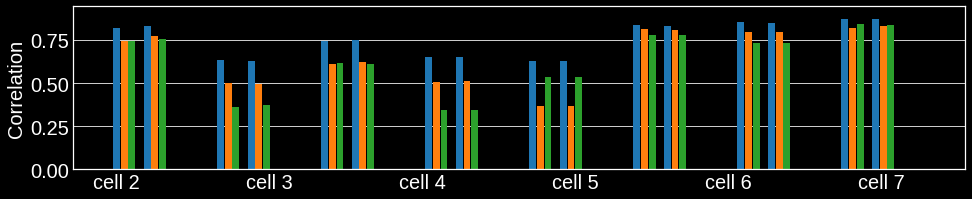

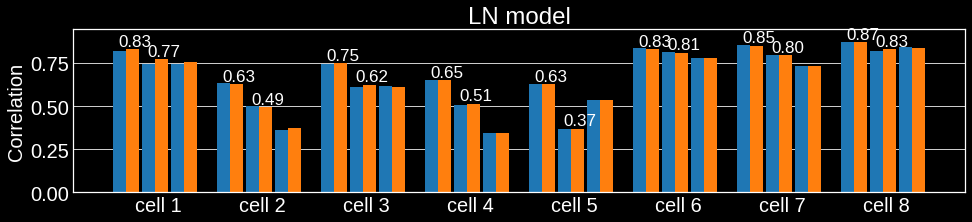

In [67]:
def model_r_bar_plot(model_r): # model_r[cell id index][data set][model_name] - dictionary
    # loop over cell id > data set > model type
    # color depends on only dataset type
    bar_width = 0.45
    dataset_spacing = 0.5
    fsize = 20 # fontsize
    n_cell = len(model_r)
    new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
    n_color = len(new_colors)
    #
    fig, ax = plt.subplots(figsize=(n_cell*2, 3))

    
    for i in range(n_cell):
        
        j = 0 # model type index
        
        for model in model_r[i].keys():

            n_model   = len(model_r[i])
            n_dataset = len(model_r[i][model])

            model_spacing = n_dataset * dataset_spacing + 0.5
            cell_spacing = n_model * model_spacing + 0.8
            
            k = 0 # dataset index                
            
            for dataset in model_r[i][model].keys():
                
                plt.bar(i*cell_spacing + j*model_spacing + k*dataset_spacing, model_r[i][model][dataset], bar_width, color=new_colors[k%n_color])
                k += 1
            #
            j += 1
        #
    ax.set_ylabel('Correlation', fontsize=fsize)
    ybottom, ytop = plt.ylim()
    ax.set_ylim(top = ytop + 0.03)
    #ax.set_xticks([i*spacing + (n_keys+0.5)*width for i in range(n_cell)])
    #ax.set_xticks([(i+0.5)*spacing for i in range(n_cell)])
    ax.set_xticklabels(['cell %d' %(i+1) for i in range(n_cell)])
    ax.tick_params(axis='both', labelsize=fsize)
    ax.tick_params(axis='x', length=0)
    ax.yaxis.grid()
    #fig.patch.set_facecolor((1, 1, 1))
    plt.title('')
    plt.show()
#
model_r_bar_plot(model_r)
    
# Bar graph
n_keys = len(r_LN_output[0].keys())
pos = list(range(n_keys)) # over dataset
width = 0.45
spacing = (n_keys*2+2)*width # spacing between cells
fig, ax = plt.subplots(figsize=(n_cell*2, 3))
fsize = 20 # fontsize
for i in range(n_cell):
    plt.bar([p +   width + i*spacing for p in pos],  r_L_output[i].values(), width, color='#1f77b4') # 1st model for each data set
    plt.bar([p + 2*width + i*spacing for p in pos], r_LN_output[i].values(), width, color='#ff7f0e') # 2nd model for each data set, innterleved.
    r = r_LN_output
    plt.text(2*width-0.5+i*spacing, r[i]['training']+0.02, '%.2f'%r[i]['training'], fontsize=fsize-3)
    plt.text(2*width+0.5+i*spacing, r[i]['test']+0.02, '%.2f'%r[i]['test'], fontsize=fsize-3)
ax.set_ylabel('Correlation', fontsize=fsize)
ybottom, ytop = plt.ylim()
ax.set_ylim(top = ytop + 0.03)
#ax.set_xticks([i*spacing + (n_keys+0.5)*width for i in range(n_cell)])
ax.set_xticks([(i+0.5)*spacing for i in range(n_cell)])
ax.set_xticklabels(['cell %d' %(i+1) for i in range(n_cell)])
ax.tick_params(axis='both', labelsize=fsize)
ax.tick_params(axis='x', length=0)
ax.yaxis.grid()
#fig.patch.set_facecolor((1, 1, 1))
plt.title('LN model')
plt.show()

#### 1. Is it overfitting to training data?
#### 2. Large variability to training / held-out data set split

In [32]:
# rolled_stim for CNN model
# rolling size = correlation size
rolled_stim = deepretina.experiments.rolling_window(stim, rolling_size)
rolled_stim = np.rollaxis(rolled_stim, axis=2, start=1)
#
labels = [data[i]['vol'] for i in range(n_cell)] # List
labels = np.array(labels)      #Convert list to 2d array for 'labels'                 
print('label :',labels.shape)

# Transpose & Truncated
labels = labels.T
truncated_labels = labels[rolling_size:]
print(' stim :', rolled_stim.shape)
print('label :', truncated_labels.shape, '- truncated and time dim was put first.')

label : (8, 71900)
 stim : (71660, 64, 240)
label : (71660, 8) - truncated and time dim was put first.


In [35]:
# split into taining and test set
# x,y : training set 

x_stim  = rolled_stim[size:-size:]      # inputs (x) for training.
test_stim  = rolled_stim[-size:]
y_label = truncated_labels[size:-size:] # labels (y) for training.
test_label = truncated_labels[-size:]

# Centering Training set?

In [46]:
# Data import to pytorch, cast data to float (or cast model to double)
y = torch.from_numpy(y_label).float()
x = torch.from_numpy(x_stim).float()
x_test = torch.from_numpy(test_stim).float()
# Add channel dimension for convolution
x = x.unsqueeze(1)
x_test = x_test.unsqueeze(1)
print(rolled_stim.shape)
print(x.shape)
print(y.shape)
#
D_stim = x.shape[1:]
print('stim(x) (ch, dim1, dim2, ...):', D_stim, 'gray stim? ch = 1')
n_cell = y.size(1)

# device
DEVICE = torch.device('cuda')
if torch.cuda.is_available():
    x = x.cuda(DEVICE) # x.to(DEVICE)
    y = y.cuda(DEVICE) # y.to(DEVICE)
    x_test = x_test.cuda(DEVICE)

(71660, 64, 240)
torch.Size([61660, 1, 64, 240])
torch.Size([61660, 8])
stim(x) (ch, dim1, dim2, ...): torch.Size([1, 64, 240]) gray stim? ch = 1


### 1 layer torch model 

In [41]:
class SimpleModel(nn.Module):
    def __init__(self, D_stim, D_out):
        # D_stim : [ch, dim1, dim2] e.g. [color, space, time]
        # D_out: # of cells (or ROIs)
        super(SimpleModel, self).__init__()
        self.conv = nn.Conv2d(D_stim[0], D_out,  kernel_size = D_stim[1:])
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)    # x.size(0) = batch number
        #x = x.view(-1, D_out)        # [batch #, output cell#]
        #return torch.tanh(x) # For RELU, self.conv1(x).clamp(min=0) For SELU, nn.functional.selu(x)
        #x = nn.functional.softplus(x)
        x = torch.tanh(x)
        # Additional conv for temporal kinetics of Ca indicator. No linear combination over channels.
        return x

torch.Size([1, 64, 240])
8
Epoch 0  Loss 0.6746
Epoch 10  Loss 0.2831
Epoch 20  Loss 0.2688
Epoch 30  Loss 0.2658


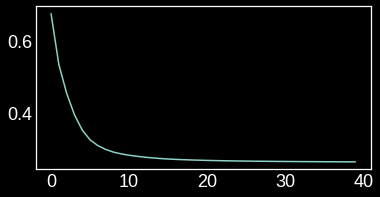

In [43]:
# Data wrapper
loader = DataLoader(TensorDataset(x,y), batch_size=8)
#
D_stim = x.shape[1:]
n_cell = y.size(1)
print('D_stim :', D_stim)
print('n_cell :', n_cell)
#
num_epoch = 40
learning_rate = 1e-5
coeff_L1 = 1e-3   # encourages to be sparse.
coeff_L2 = 5e-4
loss_log = np.zeros((num_epoch))

model = SimpleModel(D_stim, n_cell)

if torch.cuda.is_available():
    model.cuda(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = coeff_L2)

#
for epoch in range(num_epoch):
    for x_batch, y_batch in loader:
        
        y_pred = model(x_batch)
                
        # Additional regularization
        L1_loss = 0
        for param in model.parameters():
            L1_loss += coeff_L1 * param.abs().sum()
        
        loss = nn.functional.mse_loss(y_pred, y_batch) + L1_loss

            # Don't need to track intermedicate values.
            # loss = (y_pred - y).pow(2).sum()
        loss.backward() # compute gradient of loss with respect to all model parameters.
        optimizer.step()      # update params. optimizer knows learning_rate
        optimizer.zero_grad() # zero gradient

    #print(f'Epoch {epoch} Loss {loss.data}')
    loss_log[epoch] = loss.data
    if epoch % 10 == 0:
        print('Epoch %d  Loss %.4f' % (epoch, loss_log[epoch]))

# Plot loss
plt.rcParams['figure.figsize'] = [6, 3];
plt.plot(loss_log)

# Load best model?

In [466]:
importlib.reload(my)
np.set_printoptions(precision=2)

Correlation r 
	 to training data     to held-out data
Cell 0: 	    0.86, 		 0.86
Cell 1: 	    0.66, 		 0.47
Cell 2: 	    0.79, 		 0.64
Cell 3: 	    0.68, 		 0.52
Cell 4: 	    0.66, 		 0.35
Cell 5: 	    0.85, 		 0.88
Cell 6: 	    0.89, 		 0.85
Cell 7: 	    0.90, 		 0.88


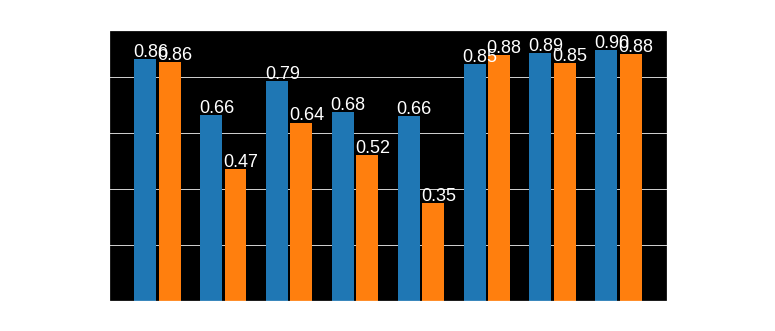

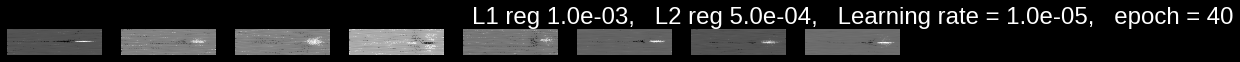

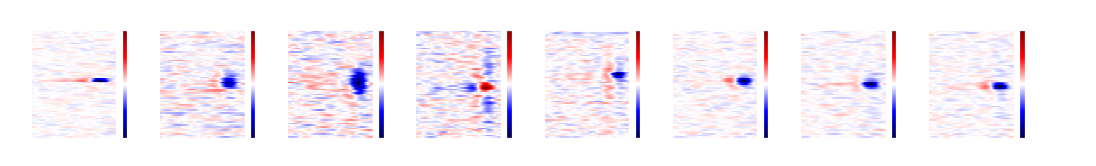

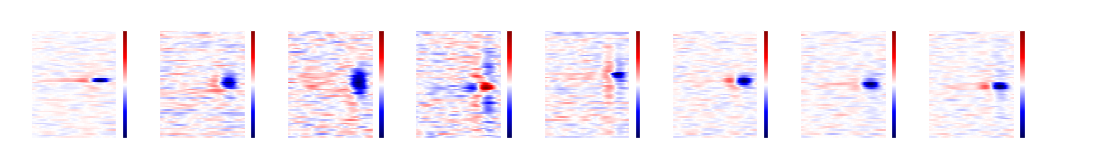

In [45]:
# model output
y_model_training = model(x).cpu().detach().numpy()
y_model_test     = model(x_test).cpu().detach().numpy()
rf_model = my.corr_with_rolled_stim(x_stim, y_model_training)
rf_label = my.corr_with_rolled_stim(x_stim, y_label)
# model weight
w_conv = model.conv.weight.data.cpu().numpy()

# Correlation to training data
keys = ['training','test']
values = [0, 0]
r = [dict(zip(keys, values)) for c in range(n_cell)]
#
print('Correlation r \n\t to training data     to held-out data')
for i in range(y_model_training.shape[1]):
    cc_training = pearsonr(y_label[:, i], y_model_training[:, i])
    cc_test  = pearsonr(test_label[:, i], y_model_test[:, i])
    print('Cell %d: \t    %.2f, \t\t %.2f' % (i, cc_training[0], cc_test[0]))
    r[i] = dict(zip(keys, [cc_training[0], cc_test[0]]))

# bar graph
pos = list(range(len(r[0].keys()))) 
width = 0.9
spacing = 3*width
fig, ax = plt.subplots(figsize=(10,5))
fsize = 20
for i in range(n_cell):
    plt.bar([p + i*spacing for p in pos],  r[i].values(), width, color=['#1f77b4', '#ff7f0e'])
    #plt.text([p-0.5 + i*spacing for p in pos], [v+0.01 for v in r[i].values()], ['%.2f' %v for v in r[i].values()], color=['#1f77b4', '#ff7f0e'])
    plt.text(-0.5+i*spacing, r[i]['training']+0.01, '%.2f'%r[i]['training'], fontsize=fsize-2)
    plt.text(0.5+i*spacing, r[i]['test']+0.01, '%.2f'%r[i]['test'], fontsize=fsize-2)
ax.set_ylabel('Correlation', fontsize=fsize)
ybottom, ytop = plt.ylim()
ax.set_ylim(top = ytop + 0.03)
ax.set_xticks([i*spacing + width/2. for i in range(n_cell)])
ax.set_xticklabels(['cell %d' %(i+1) for i in range(n_cell)])
ax.tick_params(axis='both', labelsize=fsize)
ax.tick_params(axis='x', length=0)
ax.yaxis.grid()
#fig.patch.set_facecolor((1, 1, 1))
plt.title('L1 reg %.1e,   L2 reg %.1e,   Learning rate = %.1e,   epoch = %d' % (coeff_L1, coeff_L2, learning_rate, num_epoch))
    
# Model weight RF visualization
plt.rcParams['figure.figsize'] = [16, 4];
my.plot_kernels_out_ch_cols(w_conv)
plt.title('L1 reg %.1e,   L2 reg %.1e,   Learning rate = %.1e,   epoch = %d' % (coeff_L1, coeff_L2, learning_rate, num_epoch))

# Model rev corr
plt.rcParams['figure.figsize'] = [18, 2];
my.rf_imshow(rf_model)

# Label rev corr
plt.rcParams['figure.figsize'] = [18, 2];
my.rf_imshow(rf_label)


#### 1 filter and Nonlinear + Ca indicator block

In [367]:
class LN_TemConv(nn.Module):
# 2-layer model: Conv1 + Conv2(= FC)
    def __init__(self, D_stim, H, D_out):
        # D_stim : [ch, dim1, dim2] e.g. [color, space, time]
        #     H  : num of layer1 channels
        # D_out  : num of cells (or ROIs)
        
        max_space_filtering    = D_stim[1] # conv over entire space
        max_temporal_filtering = 15;       # 2/3 s
        k1 = [max_space_filtering, max_temporal_filtering] # subunit spatiotemporal filter. # [space, time] ~ [40*7 um, (1/15Hz)*6=400 ms]
        #k2 = [D_stim[1]-max_space_filtering+1, max_temporal_filtering] # filter for integrating subunits.
        k2 = [D_stim[1]-max_space_filtering+1, D_stim[2]-max_temporal_filtering+1] # filter for integrating subunits.

        super(LN_TemConv, self).__init__()
        self.relu = nn.ReLU(inplace=True) # inplace=True: update the input directly. 
        self.softplus = nn.Softplus()
        self.conv1 = nn.Conv2d(D_stim[0], H, kernel_size = k1)
        self.conv2 = nn.Conv2d(H,     D_out, kernel_size = k2) # equivalent to FC layer.
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.softplus(x)   # nonlinearity.
        x = self.conv2(x)      # Temporal convolution.
        # x = (batch, ch, dim1, dim2)
        assert x.size(2) == 1 # Final dim1 (space) convolution should integrate all subunits.
        assert x.size(3) == 1 # Final dim1 (space) convolution should integrate all subunits.
        x = x.view(x.size(0), -1)
        x = torch.tanh(x)     # Final nonlinearity
        return x

In [335]:
D_stim = x.shape[1:]
print(D_stim)

torch.Size([1, 24, 35])


Epoch 0  Loss 2.4060
Epoch 10  Loss 2.2509
Epoch 20  Loss 2.0570
Epoch 30  Loss 1.9899
Epoch 40  Loss 2.0047
Epoch 50  Loss 2.0296
Epoch 60  Loss 2.0514
Epoch 70  Loss 2.0709
Epoch 80  Loss 2.0883
Epoch 90  Loss 2.1027


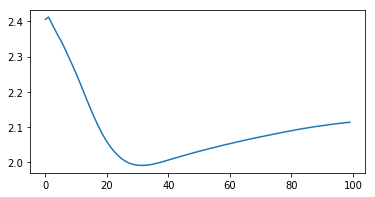

In [374]:
# data wrapper
n_cell = 1
i_cell = 0
y_single = y[:,i_cell].unsqueeze(1)
loader = DataLoader(TensorDataset(x, y_single), batch_size=8)               
#
D_stim = x.shape[1:]

#
model = LN_TemConv(D_stim, 1, n_cell)
if torch.cuda.is_available():
    model.cuda(DEVICE)
#
num_epoch = 50
learning_rate = 1e-4
coeff_L1 = 1e-3   # encourages to be sparse.
coeff_L2 = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = coeff_L2)
loss_log = np.zeros((num_epoch))
#
for epoch in range(num_epoch):
    for x_batch, y_batch in loader:
        
        y_pred = model(x_batch)
        
        # Additional regularization
        L1_loss = 0
        for param in model.parameters():
            L1_loss += coeff_L1 * param.abs().sum()
        
        loss = nn.functional.mse_loss(y_pred, y_batch) + L1_loss
            # Don't need to track intermedicate values.
            # loss = (y_pred - y).pow(2).sum()
        loss.backward() # compute gradient of loss with respect to all model parameters.
        optimizer.step()      # update params. optimizer knows learning_rate
        optimizer.zero_grad() # zero gradient
    
    #print(f'Epoch {epoch} Loss {loss.data}')
    loss_log[epoch] = loss.data
    if epoch % 10 == 0:
        print('Epoch %d  Loss %.4f' % (epoch, loss_log[epoch]))

# Plot loss 
plt.rcParams['figure.figsize'] = [6, 3];
plt.plot(loss_log)

In [ ]:
# model output
y_model_training = model(x).cpu().detach().numpy()
y_model_test     = model(x_test).cpu().detach().numpy()
rf_model = my.corr_with_rolled_stim(x_stim, y_model_training)
rf_label = my.corr_with_rolled_stim(x_stim, y_label)
# model weight
w_conv1 = model.conv1.weight.data.cpu().numpy()
w_conv2 = model.conv2.weight.data.cpu().numpy()

# Correlation to training data
keys = ['training','test']
values = [0, 0]
r = [dict(zip(keys, values)) for c in range(n_cell)]
#
print('Correlation r \n\t to training data     to held-out data')
for i in range(y_model_training.shape[1]):
    cc_training = pearsonr(y_label[:, i], y_model_training[:, i])
    cc_test  = pearsonr(test_label[:, i], y_model_test[:, i])
    print('Cell %d: \t    %.2f, \t\t %.2f' % (i, cc_training[0], cc_test[0]))
    r[i] = dict(zip(keys, [cc_training[0], cc_test[0]]))

# bar graph
pos = list(range(len(r_LN_output[0].keys()))) 
width = 0.9
spacing = 3*width
fig, ax = plt.subplots(figsize=(10,5))
fsize = 20
for i in range(n_cell):
    plt.bar([p + i*spacing for p in pos],  r[i].values(), width, color=['#1f77b4', '#ff7f0e'])
ax.set_ylabel('Correlation', fontsize=fsize)
ax.set_xticks([i*spacing + width/2. for i in range(n_cell)])
ax.set_xticklabels(['cell %d' %i for i in range(n_cell)])
ax.tick_params(axis='both', labelsize=fsize)
ax.tick_params(axis='x', length=0)
ax.yaxis.grid()
fig.patch.set_facecolor((1, 1, 1))
    
    
# Model weight RF visualization
plt.rcParams['figure.figsize'] = [16, 4];
my.plot_kernels_out_ch_cols(w_conv1)
my.plot_kernels_out_ch_cols(w_conv2)

# Model rev corr
plt.rcParams['figure.figsize'] = [3, 2];
my.rf_imshow(rf_model)

# Label rev corr
plt.rcParams['figure.figsize'] = [18, 2];
my.rf_imshow(rf_label)


In [77]:
class SimpleModel2(nn.Module):
# 2-layer model: Conv1 + Conv2(= FC)
    def __init__(self, D_stim, H, D_out):
        # D_stim : [ch, dim1, dim2] e.g. [color, space, time]
        #     H  : num of channels (types in conv1 layer) 
        # D_out  : num of cells (or ROIs)
        
        max_space_filtering    = 7; # 500 um 
        max_temporal_filtering = 15; # 2/3 s
        k1 = [max_space_filtering, max_temporal_filtering] # subunit spatiotemporal filter. # [space, time] ~ [40*7 um, (1/15Hz)*6=400 ms]
        #k2 = [D_stim[1]-max_space_filtering+1, max_temporal_filtering] # filter for integrating subunits.
        k2 = [D_stim[1]-max_space_filtering+1, D_stim[2]-max_temporal_filtering+1] # filter for integrating subunits.

        super(SimpleModel2, self).__init__()
        self.relu = nn.ReLU(inplace=True) # inplace=True: update the input directly. 
        self.softplus = nn.Softplus()
        self.conv1 = nn.Conv2d(D_stim[0], H, kernel_size = k1, stride = 1)
        self.conv2 = nn.Conv2d(H,     D_out, kernel_size = k2, stride = 1) # equivalent to FC layer.
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.softplus(x)     # rectifying nonlinearity.
        x = self.conv2(x)    # saturating nonlinearity.
        # x = (batch, ch, dim1, dim2)
        assert x.size(2) == 1 # Final dim1 (space) convolution should integrate all subunits.
        assert x.size(3) == 1 # Final dim1 (space) convolution should integrate all subunits.
        x = x.view(x.size(0), -1)
        #x = torch.tanh(x)
        return x

In [59]:
import datetime

In [68]:
n = datetime.datetime.now()
n.strftime('%Y-%m-%d-h%H-m%M')

'2019-01-25-h18-m23'

In [76]:
epoch = 5
datetime.datetime.now().strftime('%Y-%m-%d-h%H-m%M') + 'epoch %d' % epoch

'2019-01-25-h18-m26epoch 5'

In [78]:
# Model Training
#
checkpoint_dir = '/home/juyoung/Modules/1d-whitenoise-models/model-checkpoints/'
filename = checkpoint_dir + '2layerCNN-' + datetime.datetime.now().strftime('%Y-%m-%d-h%H-m%M')

# Data wrapper
loader = DataLoader(TensorDataset(x,y), batch_size=8)
#
D_stim = x.shape[1:]
n_cell = y.size(1)
print('D_stim :', D_stim)
print('n_cell :', n_cell)
#
num_epoch = 500
num_types_1st = 4
learning_rate = 5e-4
coeff_L1 = 2e-4   # encourages to be sparse.
coeff_L2 = 1e-4
loss_log = np.zeros((num_epoch))

model = SimpleModel2(D_stim, num_types_1st, n_cell)
if torch.cuda.is_available():
    model.cuda(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = coeff_L2)

#
for epoch in range(num_epoch):
    for x_batch, y_batch in loader:
        
        y_pred = model(x_batch)
        
        # Additional regularization
        L1_loss = 0
        for param in model.parameters():
            L1_loss += param.abs().sum()
            #L1_loss += model.conv2.weight.abs().sum()
        
        loss = nn.functional.mse_loss(y_pred, y_batch) + coeff_L1 * L1_loss
            # Don't need to track intermedicate values.
            # loss = (y_pred - y).pow(2).sum()
        loss.backward() # compute gradient of loss with respect to all model parameters.
        optimizer.step()      # update params. optimizer knows learning_rate
        optimizer.zero_grad() # zero gradient

    if epoch == 1:
        loss_min = loss
        
    # save model
    if loss <= loss_min:
        #torch.save(model.state_dict(), filename+'-epoch-%d'%epoch)
        torch.save(model.state_dict(), filename+'-loss-min')
    
    #print(f'Epoch {epoch} Loss {loss.data}')
    loss_log[epoch] = loss.data
    if epoch % 5 == 0:
        print('Epoch %d  Loss %.4f' % (epoch, loss_log[epoch]))
        ax = plt.subplot(111)
        ax.plot(loss_log)
        plt.show()
        
# Plot loss 
#plt.rcParams['figure.figsize'] = [6, 3];
ax.plot(loss_log)
plt.show()

D_stim : torch.Size([1, 64, 240])
n_cell : 8


KeyboardInterrupt: 

Correlation r 
	 to training data     to held-out data


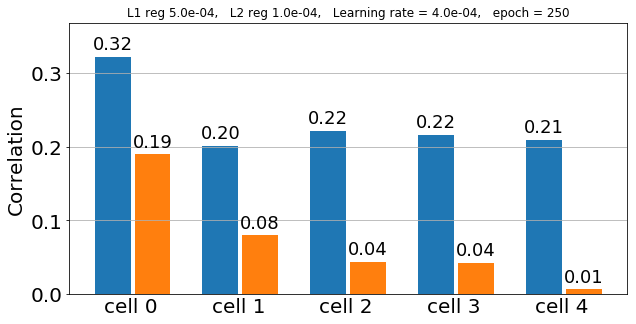

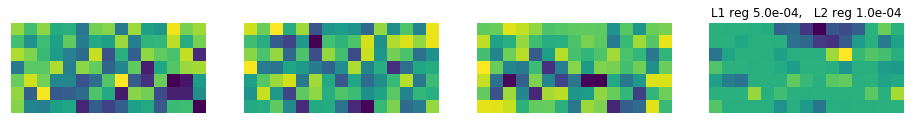

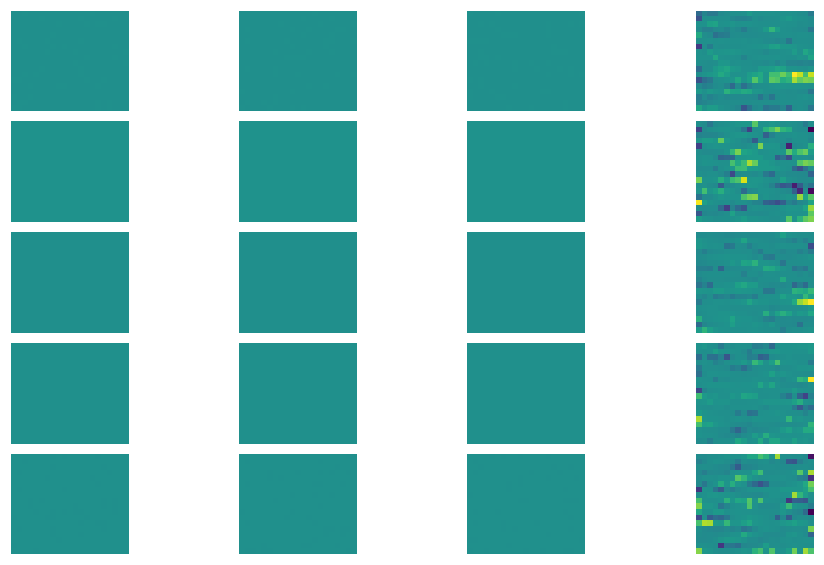

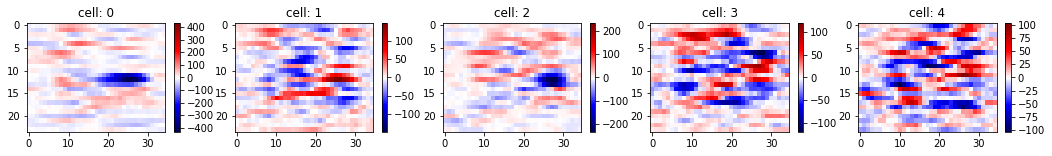

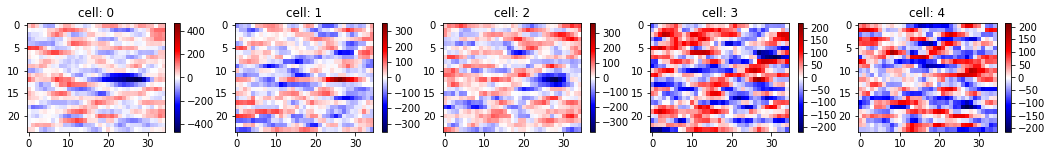

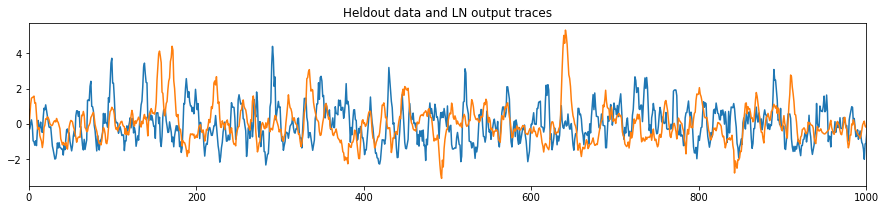

In [580]:
# model output
y_model_training = model(x).cpu().detach().numpy()
y_model_test     = model(x_test).cpu().detach().numpy()
rf_model = my.corr_with_rolled_stim(x_stim, y_model_training)
rf_label = my.corr_with_rolled_stim(x_stim, y_label)
# model weight
w_conv1 = model.conv1.weight.data.cpu().numpy()
w_conv2 = model.conv2.weight.data.cpu().numpy()

# Correlation to training data
keys = ['training','test']
values = [0, 0]
r = [dict(zip(keys, values)) for c in range(n_cell)]
#
print('Correlation r \n\t to training data     to held-out data')
for i in range(y_model_training.shape[1]):
    cc_training = pearsonr(y_label[:, i], y_model_training[:, i])
    cc_test  = pearsonr(test_label[:, i], y_model_test[:, i])
    #print('Cell %d: \t    %.2f, \t\t %.2f' % (i, cc_training[0], cc_test[0]))
    r[i] = dict(zip(keys, [cc_training[0], cc_test[0]]))

# bar graph
pos = list(range(len(r_LN_output[0].keys()))) 
width = 0.9
spacing = 3*width
fig, ax = plt.subplots(figsize=(10,5))
fsize = 20
for i in range(n_cell):
    plt.bar([p + i*spacing for p in pos],  r[i].values(), width, color=['#1f77b4', '#ff7f0e'])
    #plt.text([p-0.5 + i*spacing for p in pos], [v+0.01 for v in r[i].values()], ['%.2f' %v for v in r[i].values()], color=['#1f77b4', '#ff7f0e'])
    plt.text(-0.5+i*spacing, r[i]['training']+0.01, '%.2f'%r[i]['training'], fontsize=fsize-2)
    plt.text(0.5+i*spacing, r[i]['test']+0.01, '%.2f'%r[i]['test'], fontsize=fsize-2)
ax.set_ylabel('Correlation', fontsize=fsize)
ybottom, ytop = plt.ylim()
ax.set_ylim(top = ytop + 0.03)
ax.set_xticks([i*spacing + width/2. for i in range(n_cell)])
ax.set_xticklabels(['cell %d' %i for i in range(n_cell)])
ax.tick_params(axis='both', labelsize=fsize)
ax.tick_params(axis='x', length=0)
ax.yaxis.grid()
fig.patch.set_facecolor((1, 1, 1))
plt.title('L1 reg %.1e,   L2 reg %.1e,   Learning rate = %.1e,   epoch = %d' % (coeff_L1, coeff_L2, learning_rate, num_epoch))
    
# Model weight RF visualization
plt.rcParams['figure.figsize'] = [4*num_types_1st, 4];
my.plot_kernels_out_ch_cols(w_conv1)
plt.title('L1 reg %.1e,   L2 reg %.1e' % (coeff_L1, coeff_L2))
plt.rcParams['figure.figsize'] = [16, 2*n_cell];
my.plot_kernels_in_ch_cols(w_conv2)
#plt.title('L1 reg %.1e,   L2 reg %.1e' % (coeff_L1, coeff_L2))

# Model rev corr
plt.rcParams['figure.figsize'] = [18, 2];
my.rf_imshow(rf_model)

# Label rev corr
plt.rcParams['figure.figsize'] = [18, 2];
my.rf_imshow(rf_label)

# Plot trace
i_cell = 0
y_model_test -= np.mean(y_model_test, axis=0)
y_model_test /= np.std(y_model_test, axis=0)
plt.rcParams['figure.figsize'] = [18, 1];
#fig = plt.figure()
fig, ax = plt.subplots(figsize=(15,3))
plt.plot(labels[k:k+size, i_cell])
plt.plot(y_model_test[:, i_cell])
ax.set_xlim([0, 1000])
plt.title('Heldout data and LN output traces')
fig.patch.set_facecolor((1, 1, 1))

In [509]:
importlib.reload(my)
np.set_printoptions(precision=2)

In [ ]:
# 4D tensor visualization for pytorch model
plt.rcParams['figure.figsize'] = [12, 4];    
w_conv1 = model.conv1.weight.data.cpu().numpy()
w_conv2 = model.conv2.weight.data.cpu().numpy()
plot_kernels_out_ch_cols(w_conv1)
plt.rcParams['figure.figsize'] = [16, 12];
plot_kernels_in_ch_cols(w_conv2)

# model output: STA and correlation
y_model = model(x).cpu().detach().numpy()
model_rf = corr_with_rolled_stim(rolled_stim, y_model)
plt.rcParams['figure.figsize'] = [6, 3];
print('Rev correlation of Model output')
rf_imshow(model_rf)

### CNN TF model

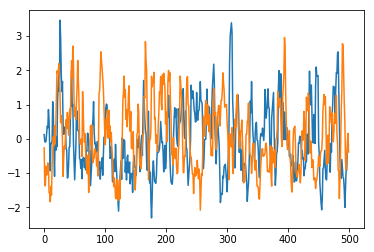

In [110]:
# Does Test label actually look similar to train label?
c = 0
data_size = 500
training_set_size = 14000
plt.plot(truncated_labels[data_after:data_after+data_size, c])
plt.plot(truncated_labels[training_set_size:training_set_size+data_size, c])

In [ ]:
# Center labels ?
truncated_labels -= np.mean(truncated_labels, axis=0)
truncated_labels /= np.std(truncated_labels, axis=0)

In [108]:
# Tf model
tf.reset_default_graph()

In [109]:
np.floor(55000/2000)

27.0

In [110]:
model_labels.shape[1]

2

### All_variables to model again? + perturbation?
Contiribution of i-th filter (or subunit only?)

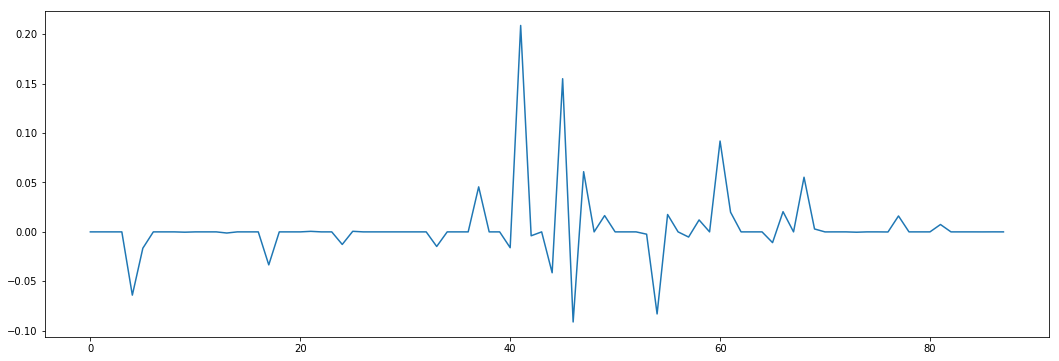

In [50]:
# plt.imshow(all_variables[2][:, 0], aspect='auto', cmap='seismic')
plt.plot(all_variables[2][:, 0])

In [44]:
[a.shape for a in all_variables]

[(3, 35, 4), (4,), (88, 2), (2,)]

In [ ]:
pearsonr(test_out[:1000, 0], test_labels[:1000, 0])

In [ ]:
for i in range(n_cell):
    cc = pearsonr(test_out[:1000, i], test_labels[:1000, i])
    print(cc[0]) # 2nd output is p-value
    plt.figure()
    plt.plot(test_out[:500, i])
    plt.plot(test_labels[:500, i])

In [ ]:
saved_test_out = test_out
saved_test_labels = test_labels

In [ ]:
plt.plot(test_out[:100, 0])
plt.plot(test_labels[:100, 0])

In [ ]:
len(all_variables)

In [ ]:
for v in all_variables:
    print(v.shape)

In [ ]:
plt.imshow(receptive_fields[0])

In [ ]:
test_mse

In [ ]:
test_out.shape

In [ ]:
test_labels.shape

In [ ]:
plt.plot(test_out[:100, 0])
plt.plot(test_labels[:100, 0])

In [ ]:
flattened_layer2.shape

In [ ]:
layer2.get_shape()

# Qualitative comparison

In [ ]:
cell_id = 2

fig = plt.figure(figsize=(1.5, 0.5))
random_start = 6900
# random_start = np.random.choice(9995 - 200)
# m = qualitative_comparison['model'][random_start:random_start+200] - np.mean(qualitative_comparison['model'])
# m /= np.std(qualitative_comparison['model'])
# b = qualitative_comparison['bipolar'][random_start:random_start+200] - np.mean(qualitative_comparison['bipolar'])
# b /= np.std(qualitative_comparison['bipolar'])
m = test_out[:400, cell_id] - np.mean(test_out[:, cell_id])
m /= np.std(test_out[:, cell_id])
b = test_labels[:400, cell_id] - np.mean(test_labels[:400, cell_id])
b /= np.std(test_labels[:, cell_id])

plt.plot(np.linspace(0, 2, 400), b, color='k', linewidth=1)
plt.plot(np.linspace(0, 2, 400), m, color='b', linewidth=2, alpha=0.5)
adjust_spines(plt.gca())

ax = plt.gca()
majorLocator = MultipleLocator(2)
majorFormatter = FormatStrFormatter('%d')
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.spines['left'].set_visible(False)
ax.yaxis.set_visible(False)
plt.xlabel('Seconds (s)')